<a href="https://colab.research.google.com/github/curiosity806/2020_dacon_satellite_precipitation/blob/bogyung/Dacon2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [1]:
import glob
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import seaborn as sns
from tqdm import tqdm
import matplotlib.pyplot as plt
import tensorflow as tf
import os
import random
from tensorflow.keras.layers import Dense, Conv2D, Dropout, Conv2DTranspose, MaxPooling2D, BatchNormalization, Activation, concatenate, Input, GlobalAveragePooling2D
from tensorflow.keras import Model
import warnings
import gc
 
warnings.filterwarnings("ignore")

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
tf.__version__

'2.2.0-rc3'

## 데이터 불러오기

In [0]:
# 훈련 데이터 및 자가 test데이터 불러오기
train = np.load('/content/drive/My Drive/2020 Kaggle Study/data/orbit_no_shuffle/train_add.npy')
#test = np.load('/content/drive/My Drive/2020 Kaggle Study/data/32bits_data/test_32bits.npy')
# 테스트 데이터 받아오기
#test_submit = np.load('/content/drive/My Drive/2020 Kaggle Study/data/test.npy')

In [28]:
train.shape

(76345, 40, 40, 15)

In [0]:
test.shape

(7639, 40, 40, 15)

In [0]:
# 재생산성을 위해 시드 고정
np.random.seed(7)
random.seed(7)
tf.random.set_seed(7)

# 이상치 분석

In [0]:
# feature 0~13
for i in range(14):
  globals()["train_f" + str(i)] = train[:,:,:,i].flatten().astype(np.float16)

In [0]:
# feature 14(target)
train_y = train[:,:,:,-1].flatten().astype(np.float16)

In [6]:
# 결측치(-9999.x)를 -1으로 바꿔줌
train_y[train_y < 0] = -1
train_y.min()

-1.0

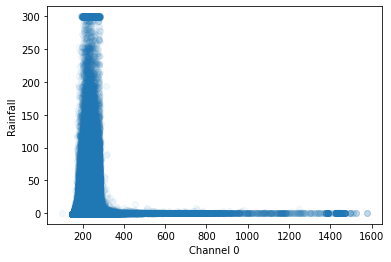

In [7]:
# 셔플 안된거
plt.scatter(x=train_f0, y=train_y, alpha=.05)
plt.ylabel('Rainfall')
plt.xlabel('Channel 0')
plt.show()

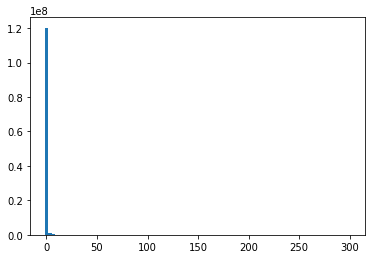

In [10]:
plt.hist(train_y, bins=100);

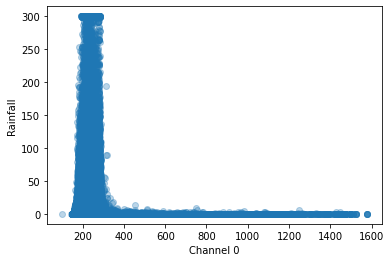

In [0]:
plt.scatter(x=train_f0, y=train_y, alpha=.3)
plt.ylabel('Rainfall')
plt.xlabel('Channel 0')
plt.show()

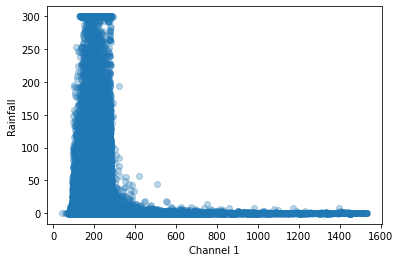

In [0]:
plt.scatter(x=train_f1, y=train_y, alpha=.3)
plt.ylabel('Rainfall')
plt.xlabel('Channel 1')
plt.show()

2개의 outlier data

In [11]:
((train_f1>400) & (train_y>25)).sum()

2

In [12]:
# outlier index
out1 = np.where((train_f1>400) & (train_y>25))[0]
out1

array([ 26737380, 105525975])

In [13]:
outlier1 = np.unique(out1//1600)
outlier1

array([16710, 65953])

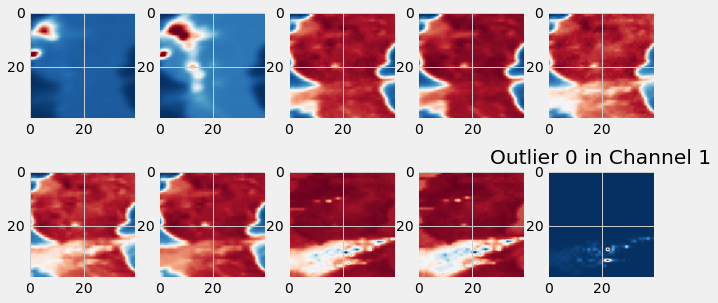

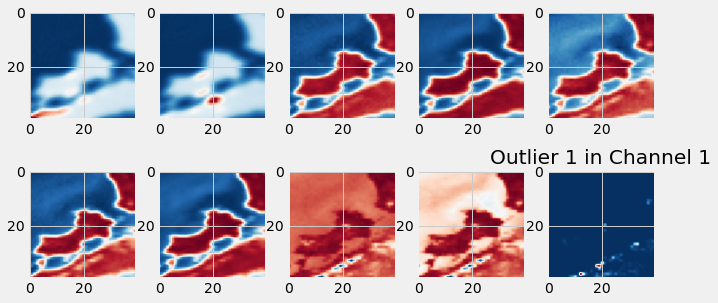

In [0]:
color_map = plt.cm.get_cmap('RdBu')
color_map = color_map.reversed()
plt.style.use('fivethirtyeight')

for n in range(len(out1)):
  plt.figure(figsize=(10,5))
  for i in range(9):
    outlier = out1[n]//1600
    plt.subplot(2,5,i+1)
    plt.imshow(train[outlier, :, :, i], cmap=color_map)
  plt.subplot(2,5,10)
  plt.imshow(train[outlier, :,:,-1], cmap = color_map)
  plt.title(f'Outlier {n} in Channel 1')
  plt.show()

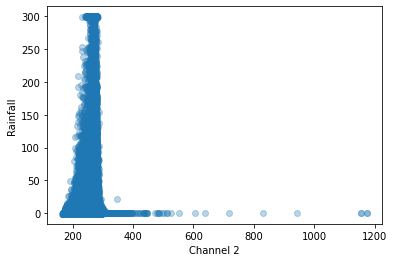

In [0]:
plt.scatter(x=train_f2, y=train_y, alpha=.3)
plt.ylabel('Rainfall')
plt.xlabel('Channel 2')
plt.show()

(0.0, 350.0)

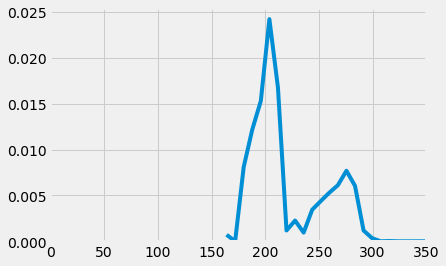

In [50]:
sns.kdeplot(train_f2)
plt.xlim(0,350)

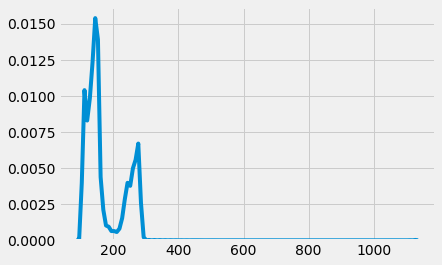

In [51]:
sns.kdeplot(train_f3)

(0.0, 350.0)

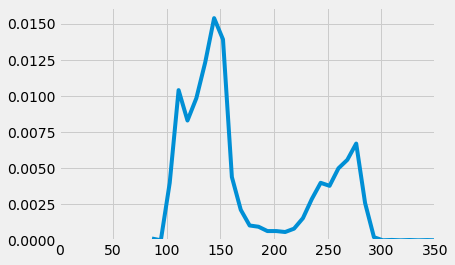

In [52]:
sns.kdeplot(train_f3)
plt.xlim(0,350)

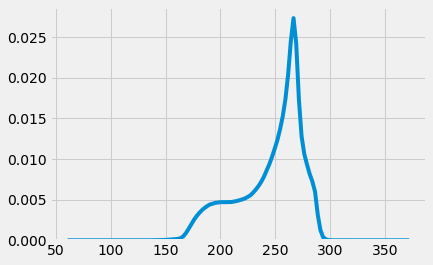

In [54]:
sns.kdeplot(train_f8)
#plt.xlim(0,350)

In [35]:
out0 = np.where(train_f2>600)[0]
print(out0)
outlier0 = np.unique(out0//1600)


[ 22878009  22878050  22878092  81731574 101774779 101774780 101774819
 101774820 117255822]


In [41]:
outlier0

array([14298, 51082, 63609, 73284])

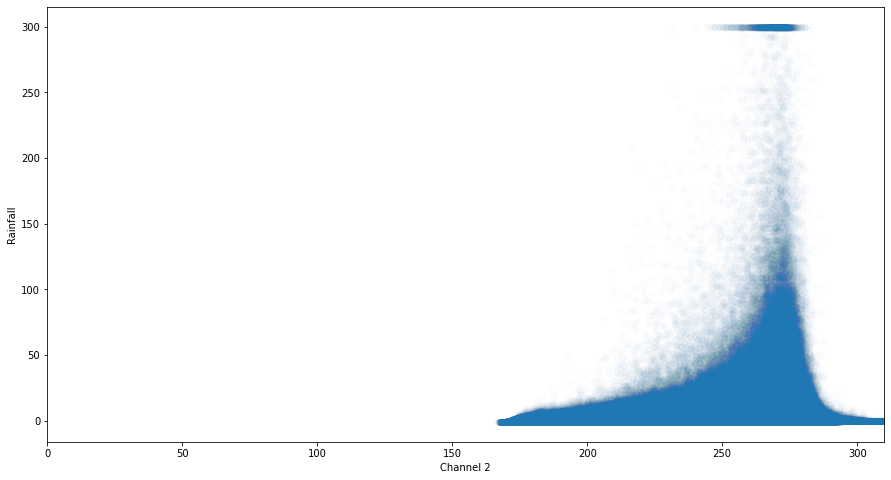

In [33]:
plt.figure(figsize=(15,8))
plt.scatter(x=train_f2, y=train_y, alpha=.01)
plt.ylabel('Rainfall')
plt.xlabel('Channel 2')
plt.xlim(0,310)
plt.show()

5개의 outlier data(픽셀 10개)

In [14]:
((train_f2>300) & (train_y>20)).sum()

1

In [0]:
(train_f2>600).sum() # target은 전부 다 0

9

In [15]:
out2 = np.where(((train_f2>300) & (train_y>20))|(train_f2>600))[0]
out2

array([ 22878009,  22878050,  22878092,  65494800,  81731574, 101774779,
       101774780, 101774819, 101774820, 117255822])

In [16]:
outlier2 = np.unique(out2//1600)
outlier2

array([14298, 40934, 51082, 63609, 73284])

In [38]:
outlier0

array([14298, 51082, 63609, 73284])

In [44]:
out0

array([ 22878009,  22878050,  22878092,  81731574, 101774779, 101774780,
       101774819, 101774820, 117255822])

In [45]:
22878009//1600

14298

In [46]:
22878009-14298*1600

1209

In [47]:
22878050-14298*1600

1250

In [48]:
22878092-14298*1600

1292

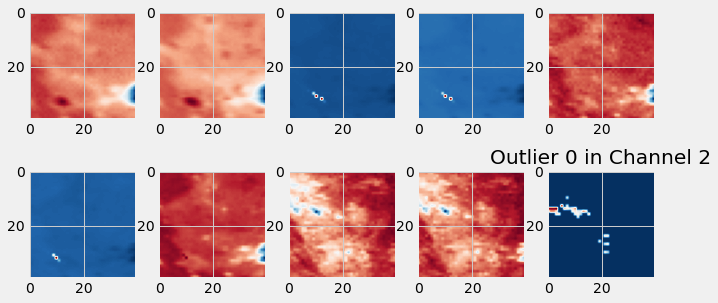

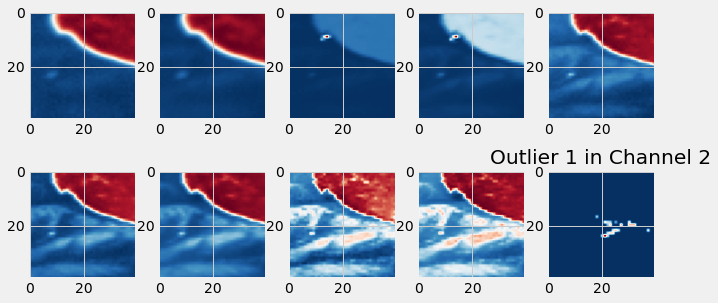

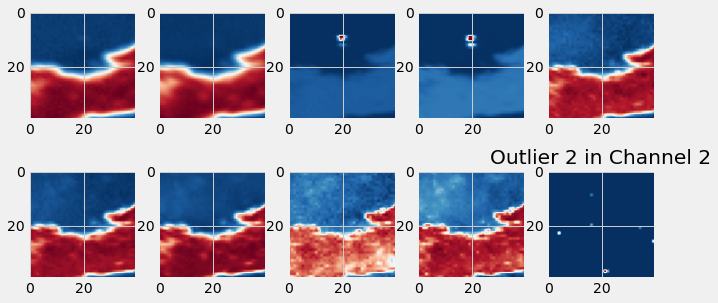

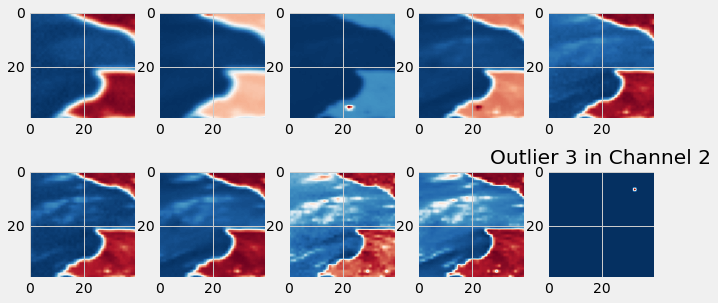

In [36]:
color_map = plt.cm.get_cmap('RdBu')
color_map = color_map.reversed()
plt.style.use('fivethirtyeight')

for n in range(len(np.unique(out0//1600))):
  plt.figure(figsize=(10,5))
  for i in range(9):
    outlier = np.unique(out0//1600)[n] # 중복 제거(같은 data 속 서로 다른 픽셀)
    plt.subplot(2,5,i+1)
    plt.imshow(train[outlier, :, :, i], cmap=color_map)
  plt.subplot(2,5,10)
  plt.imshow(train[outlier, :,:,-1], cmap = color_map)
  plt.title(f'Outlier {n} in Channel 2')
  plt.show()

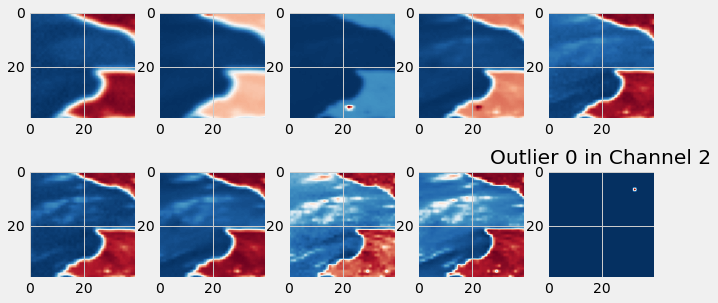

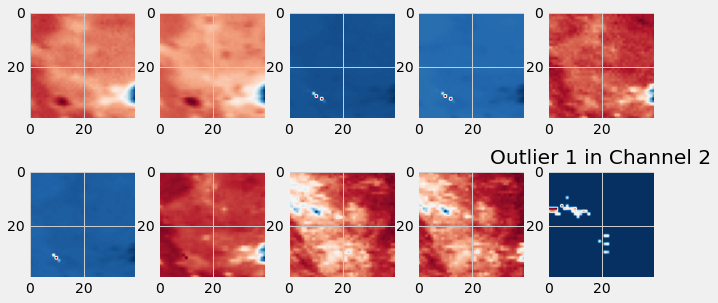

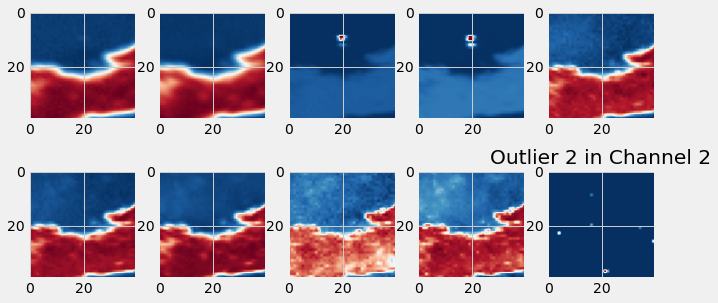

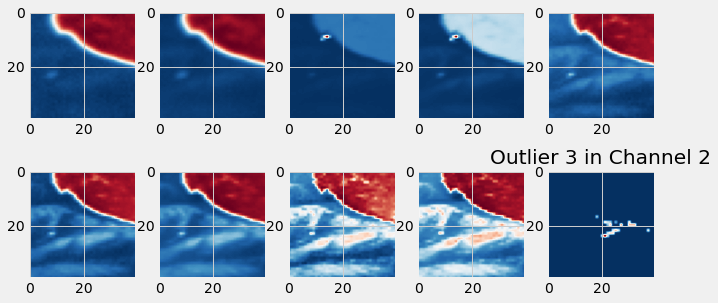

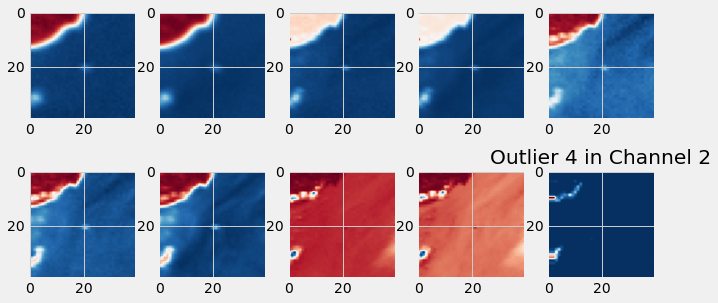

In [0]:
color_map = plt.cm.get_cmap('RdBu')
color_map = color_map.reversed()
plt.style.use('fivethirtyeight')

for n in range(len(np.unique(out2//1600))):
  plt.figure(figsize=(10,5))
  for i in range(9):
    outlier = np.unique(out2//1600)[n] # 중복 제거(같은 data 속 서로 다른 픽셀)
    plt.subplot(2,5,i+1)
    plt.imshow(train[outlier, :, :, i], cmap=color_map)
  plt.subplot(2,5,10)
  plt.imshow(train[outlier, :,:,-1], cmap = color_map)
  plt.title(f'Outlier {n} in Channel 2')
  plt.show()

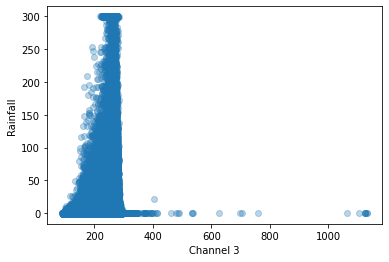

In [0]:
plt.scatter(x=train_f3, y=train_y, alpha=.3)
plt.ylabel('Rainfall')
plt.xlabel('Channel 3')
plt.show()

In [17]:
out3 = np.where(((train_f3>400) & (train_y>20))|(train_f3>600))[0]
out3

array([ 22878050,  22878092,  36821309,  36821310,  36821311,  36821350,
        65494800, 101774779, 101774780, 101774819, 101774820, 101774899,
       101774900])

In [18]:
outlier3 = np.unique(out3//1600)
outlier3

array([14298, 23013, 40934, 63609])

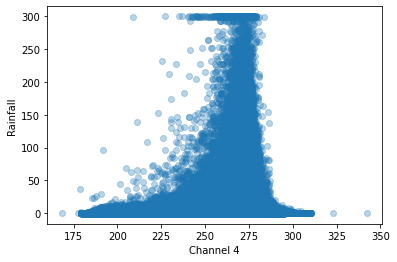

In [0]:
plt.scatter(x=train_f4, y=train_y, alpha=.3)
plt.ylabel('Rainfall')
plt.xlabel('Channel 4')
plt.show()

In [0]:
(((train_f4<200) & (train_y>30)) | ((train_f4<250) & (train_y>150)) | ((train_f4<225) & (train_y>75) & (train_y<=150)) | (train_f4<170) | (train_f4>320)).sum()

47

In [19]:
out4 = np.where(((train_f4<200) & (train_y>30)) | ((train_f4<250) & (train_y>150)) | ((train_f4<225) & (train_y>75) & (train_y<=150)) | (train_f4<170) | (train_f4>320))[0]
out4

array([ 12074415,  12074456,  17401471,  18502218,  18502221,  19038295,
        20376015,  23200824,  23764431,  24090108,  33933171,  46347513,
        46347514,  54283838,  55175997,  55682537,  55682577,  57139855,
        58837784,  61182068,  62222023,  79582698,  79582737,  79582741,
        88263260,  88263427,  88263428,  88263592,  88263594,  88318979,
        90692079,  91227742,  92753354,  94893397, 101038720, 102097294,
       102888280, 102888281, 106749067, 106749068, 108348059, 109188433,
       110898712, 117292838, 117292839, 117292877, 118229941])

In [20]:
outlier4 = np.unique(out4//1600)
outlier4

array([ 7546, 10875, 11563, 11898, 12735, 14500, 14852, 15056, 21208,
       28967, 33927, 34484, 34801, 35712, 36773, 38238, 38888, 49739,
       55164, 55199, 56682, 57017, 57970, 59308, 63149, 63810, 64305,
       66718, 67717, 68242, 69311, 73308, 73893])

In [0]:
print(len(out4), len(np.unique(out4//1600)))

47 33


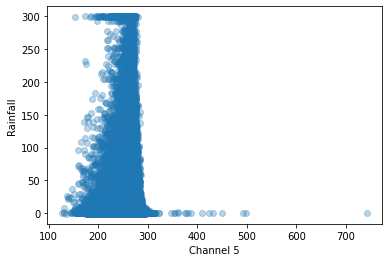

In [0]:
plt.scatter(x=train_f5, y=train_y, alpha=.3)
plt.ylabel('Rainfall')
plt.xlabel('Channel 5')
plt.show()

In [0]:
(((train_f5<200) & (train_y>200)) | (train_f5>400)).sum()

19

In [21]:
out5 = np.where(((train_f5<200) & (train_y>200)) | (train_f5>400))[0]
out5

array([ 17401471,  18502218,  20062519,  20062558,  20062559,  22878049,
        22878090,  33933171,  36009654,  57139855,  79582698,  79582737,
        79582741,  91227742,  92753354,  95606616, 108348059, 117292838,
       117292877])

In [22]:
outlier5 = np.unique(out5//1600)
outlier5

array([10875, 11563, 12539, 14298, 21208, 22506, 35712, 49739, 57017,
       57970, 59754, 67717, 73308])

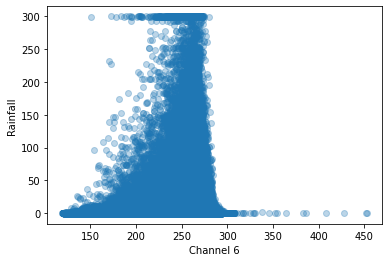

In [0]:
plt.scatter(x=train_f6, y=train_y, alpha=.3)
plt.ylabel('Rainfall')
plt.xlabel('Channel 6')
plt.show()

In [0]:
(((train_f6<200) & (train_y>200)) | (train_f6>350)).sum()

22

In [23]:
out6 = np.where(((train_f6<200) & (train_y>200)) | (train_f6>350))[0]
out6

array([ 17401471,  18502218,  20062519,  20062558,  20062559,  33933171,
        36009654,  46347513,  51019109,  57139855,  58837784,  79582698,
        79582737,  79582741,  91227742,  92753354,  95606576,  95606577,
        95606616, 108348059, 117292838, 117292877])

In [24]:
outlier6 = np.unique(out6//1600)
outlier6

array([10875, 11563, 12539, 21208, 22506, 28967, 31886, 35712, 36773,
       49739, 57017, 57970, 59754, 67717, 73308])

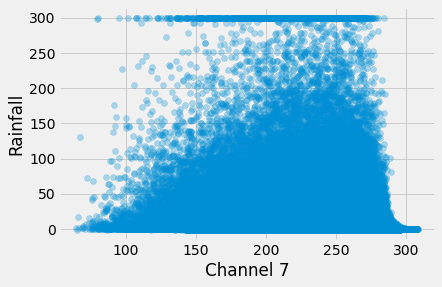

In [0]:
plt.scatter(x=train_f7, y=train_y, alpha=.3)
plt.ylabel('Rainfall')
plt.xlabel('Channel 7')
plt.show()

In [25]:
out7 = np.where((train_f7<100)&(train_y>100))[0]
out7

array([ 19058416,  54283837,  54283838,  57139855,  79582698,  79582738,
        91227581,  91227664,  91227742,  94893397, 103312203, 108348059])

In [26]:
outlier7 = np.unique(out7//1600)
outlier7

array([11911, 33927, 35712, 49739, 57017, 59308, 64570, 67717])

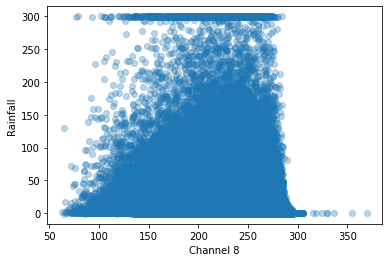

In [0]:
plt.scatter(x=train_f8, y=train_y, alpha=.3)
plt.ylabel('Rainfall')
plt.xlabel('Channel 8')
plt.show()

In [27]:
out8 = np.where((train_f8<100)&(train_y>100))[0]
out8

array([ 18316413,  19058416,  24090070,  54283837,  54283838,  57139855,
        73418672,  79582698,  79582738,  91227581,  91227664,  91227742,
        94893397, 103312203, 108348059])

In [28]:
outlier8 = np.unique(out8//1600)
outlier8

array([11447, 11911, 15056, 33927, 35712, 45886, 49739, 57017, 59308,
       64570, 67717])

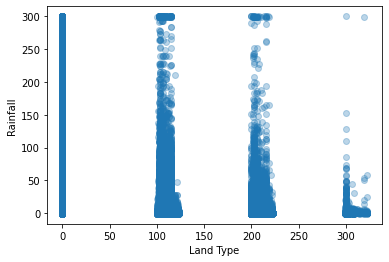

In [0]:
plt.scatter(x=train_f9, y=train_y, alpha=.3)
plt.ylabel('Rainfall')
plt.xlabel('Land Type')
plt.show()

In [29]:
outlier_all = np.concatenate([outlier1, outlier2, outlier3, outlier4, outlier5, outlier6, outlier7, outlier8])
outlier_all = np.unique(outlier_all)
outlier_all # 이상치 픽셀이 1개 이상 포함된 데이터의 index

array([ 7546, 10875, 11447, 11563, 11898, 11911, 12539, 12735, 14298,
       14500, 14852, 15056, 16710, 21208, 22506, 23013, 28967, 31886,
       33927, 34484, 34801, 35712, 36773, 38238, 38888, 40934, 45886,
       49739, 51082, 55164, 55199, 56682, 57017, 57970, 59308, 59754,
       63149, 63609, 63810, 64305, 64570, 65953, 66718, 67717, 68242,
       69311, 73284, 73308, 73893])

In [30]:
out_all = np.concatenate([out1, out2, out3, out4, out5, out6, out7, out8])
out_all = np.unique(out_all)
out_all

array([ 12074415,  12074456,  17401471,  18316413,  18502218,  18502221,
        19038295,  19058416,  20062519,  20062558,  20062559,  20376015,
        22878009,  22878049,  22878050,  22878090,  22878092,  23200824,
        23764431,  24090070,  24090108,  26737380,  33933171,  36009654,
        36821309,  36821310,  36821311,  36821350,  46347513,  46347514,
        51019109,  54283837,  54283838,  55175997,  55682537,  55682577,
        57139855,  58837784,  61182068,  62222023,  65494800,  73418672,
        79582698,  79582737,  79582738,  79582741,  81731574,  88263260,
        88263427,  88263428,  88263592,  88263594,  88318979,  90692079,
        91227581,  91227664,  91227742,  92753354,  94893397,  95606576,
        95606577,  95606616, 101038720, 101774779, 101774780, 101774819,
       101774820, 101774899, 101774900, 102097294, 102888280, 102888281,
       103312203, 105525975, 106749067, 106749068, 108348059, 109188433,
       110898712, 117255822, 117292838, 117292839, 

In [0]:
remain = []
for i in list(range(train.shape[0])):
  if i in outlier_all: pass
  else: remain.append(i)

In [0]:
train = train[remain, :,:,:] # 이상치 제거

# Feature Normalization

In [10]:
train.shape

(76345, 40, 40, 15)

In [31]:
train[:,:,:,-2]

array([[[ 5.574192 ,  5.574192 ,  5.574192 , ...,  4.796376 ,
          4.8175697,  4.797518 ],
        [ 5.6983066,  5.6983066,  5.656905 , ...,  4.9204044,
          4.9002275,  4.921524 ],
        [ 5.8224344,  5.781039 ,  5.781039 , ...,  5.044401 ,
          5.02422  ,  5.004162 ],
        ...,
        [ 9.667927 ,  9.667927 ,  9.667927 , ...,  8.883668 ,
          8.904502 ,  8.8842325],
        [ 9.791889 ,  9.750565 ,  9.750565 , ...,  9.007321 ,
          8.986925 ,  8.96665  ],
        [ 9.874516 ,  9.874516 ,  9.874516 , ...,  9.130981 ,
          9.110574 ,  9.090286 ]],

       [[ 9.998442 ,  9.998442 ,  9.998442 , ...,  9.213408 ,
          9.234242 ,  9.213947 ],
        [10.122347 , 10.122347 , 10.081039 , ...,  9.337085 ,
          9.316663 ,  9.33761  ],
        [10.246253 , 10.20492  , 10.20492  , ...,  9.460755 ,
          9.440328 ,  9.420021 ],
        ...,
        [14.082207 , 14.082207 , 14.041026 , ..., 13.286203 ,
         13.265453 , 13.285877 ],
        [14.

In [0]:
# StandardScaler(X): 평균이 0과 표준편차가 1이 되도록 변환.
# RobustScaler(X): 중앙값(median)이 0, IQR(interquartile range)이 1이 되도록 변환.
# MinMaxScaler(X): 최대값이 각각 1, 최소값이 0이 되도록 변환
# MaxAbsScaler(X): 0을 기준으로 절대값이 가장 큰 수가 1또는 -1이 되도록 변환

In [0]:
from sklearn.preprocessing import RobustScaler

In [13]:
transformer = RobustScaler().fit(train_f0.reshape(-1, 1))
transformer

RobustScaler(copy=True, quantile_range=(25.0, 75.0), with_centering=True,
             with_scaling=True)

(array([1.0000000e+00, 0.0000000e+00, 1.0000000e+00, 6.4042750e+06,
        6.7560191e+07, 1.2184296e+07, 1.6844600e+06, 1.0342310e+06,
        9.3157400e+05, 2.8285070e+06, 1.0634208e+07, 1.2147960e+07,
        6.2610520e+06, 4.5242000e+05, 1.0616000e+04, 4.6070000e+03,
        2.8620000e+03, 1.9890000e+03, 1.3370000e+03, 1.0170000e+03,
        7.7800000e+02, 5.9800000e+02, 5.2100000e+02, 4.6000000e+02,
        3.8600000e+02, 3.3000000e+02, 2.7500000e+02, 2.4500000e+02,
        2.2200000e+02, 1.9900000e+02, 1.5600000e+02, 1.6900000e+02,
        1.4300000e+02, 1.4600000e+02, 1.1400000e+02, 9.8000000e+01,
        8.8000000e+01, 7.2000000e+01, 7.9000000e+01, 7.5000000e+01,
        6.2000000e+01, 6.3000000e+01, 5.7000000e+01, 4.6000000e+01,
        6.1000000e+01, 4.9000000e+01, 4.0000000e+01, 3.6000000e+01,
        3.3000000e+01, 3.3000000e+01, 2.2000000e+01, 3.2000000e+01,
        2.7000000e+01, 2.5000000e+01, 2.1000000e+01, 2.4000000e+01,
        1.7000000e+01, 1.9000000e+01, 1.9000000e

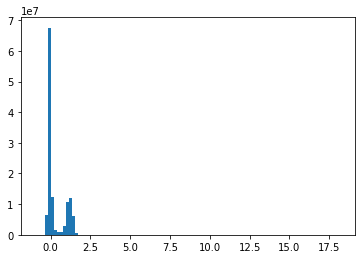

In [18]:
plt.hist(transformer.transform(train_f0.reshape(-1, 1)), bins=100)

(array([1.0000000e+00, 0.0000000e+00, 1.0000000e+00, 6.4042750e+06,
        6.7560191e+07, 1.2184296e+07, 1.6844600e+06, 1.0342310e+06,
        9.3157400e+05, 2.8285070e+06, 1.0634208e+07, 1.2147960e+07,
        6.2610520e+06, 4.5242000e+05, 1.0616000e+04, 4.6070000e+03,
        2.8620000e+03, 1.9890000e+03, 1.3370000e+03, 1.0170000e+03,
        7.7800000e+02, 5.9800000e+02, 5.2100000e+02, 4.6000000e+02,
        3.8600000e+02, 3.3000000e+02, 2.7500000e+02, 2.4500000e+02,
        2.2200000e+02, 1.9900000e+02, 1.5600000e+02, 1.6900000e+02,
        1.4300000e+02, 1.4600000e+02, 1.1400000e+02, 9.8000000e+01,
        8.8000000e+01, 7.5000000e+01, 7.6000000e+01, 7.8000000e+01,
        5.9000000e+01, 6.5000000e+01, 5.5000000e+01, 4.8000000e+01,
        5.9000000e+01, 4.9000000e+01, 4.0000000e+01, 3.6000000e+01,
        3.3000000e+01, 3.3000000e+01, 2.2000000e+01, 3.2000000e+01,
        2.8000000e+01, 2.4000000e+01, 2.1000000e+01, 2.5000000e+01,
        1.8000000e+01, 1.8000000e+01, 1.8000000e

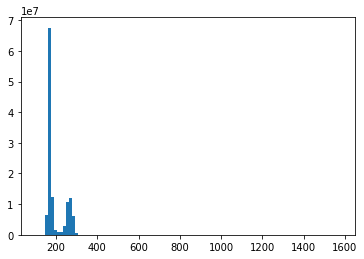

In [19]:
plt.hist(train_f0, bins=100)

# Channel별 값들의 특성 파악 및 값의 분포 알아보기

In [0]:
over_299 = train[:,:,:,-1].flatten()
over_299 = over_299[over_299 > 299]

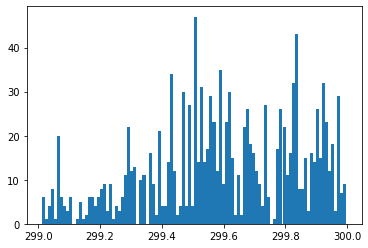

In [67]:
plt.hist(over_299, bins=100); # 강수량 299~300

## 시각화 하기

In [0]:
import seaborn as sns

color_map = plt.cm.get_cmap('RdBu')
color_map = color_map.reversed()
plt.style.use('fivethirtyeight')
plt.figure(figsize=(10, 5))

for i in range(9):
    plt.subplot(2,5,i+1)
    plt.imshow(image_sample[:, :, i], cmap=color_map)

plt.subplot(2,5,10)
plt.imshow(image_sample[:,:,-1], cmap = color_map)
plt.show()

In [0]:
image_sample = train_p0[8]

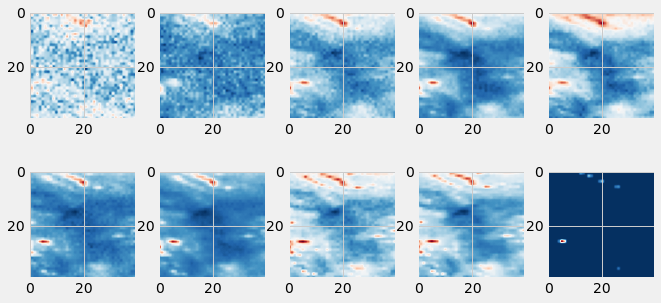

In [0]:
plt.style.use('fivethirtyeight')
plt.figure(figsize=(10, 5))

for i in range(9):
    plt.subplot(2,5,i+1)
    plt.imshow(image_sample[:, :, i], cmap=color_map)

plt.subplot(2,5,10)
plt.imshow(image_sample[:,:,-1], cmap = color_map)
plt.show()

## 모델만들기

In [0]:
def build_model(input_layer, start_neurons):
    
    # 40 x 40 -> 20 x 20
    conv1 = Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(input_layer) # filters, kernel_size
    conv1 = Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(conv1)
    pool1 = BatchNormalization()(conv1)
    pool1 = MaxPooling2D((2, 2))(pool1)
    pool1 = Dropout(0.25)(pool1)

    # 20 x 20 -> 10 x 10
    conv2 = Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same")(pool1)
    conv2 = Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same")(conv2)
    pool2 = BatchNormalization()(conv2)
    pool2 = MaxPooling2D((2, 2))(pool2)
    pool2 = Dropout(0.25)(pool2)

    # 10 x 10 
    convm = Conv2D(start_neurons * 4, (3, 3), activation="relu", padding="same")(pool2)

    # 10 x 10 -> 20 x 20
    deconv2 = Conv2DTranspose(start_neurons * 2, (3, 3), strides=(2, 2), padding="same")(convm)
    uconv2 = concatenate([deconv2, conv2])
    uconv2 = Dropout(0.25)(uconv2)
    uconv2 = Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same")(uconv2)
    uconv2 = Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same")(uconv2)
    uconv2 = BatchNormalization()(uconv2)

    # 20 x 20 -> 40 x 40
    deconv1 = Conv2DTranspose(start_neurons * 1, (3, 3), strides=(2, 2), padding="same")(uconv2)
    uconv1 = concatenate([deconv1, conv1])
    uconv1 = Dropout(0.25)(uconv1)
    uconv1 = Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(uconv1)
    uconv1 = Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(uconv1)
    uconv1 = BatchNormalization()(uconv1)
    uconv1 = Dropout(0.25)(uconv1)
    output_layer = Conv2D(1, (1,1), padding="same", activation='relu')(uconv1)
    
    return output_layer

input_layer = Input((40, 40, 9))
output_layer = build_model(input_layer, 32)

In [0]:
model = Model(input_layer, output_layer)

In [0]:
from sklearn.metrics import f1_score

def mae(y_true, y_pred) :
    
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    
    y_true = y_true.reshape(1, -1)[0]
    
    y_pred = y_pred.reshape(1, -1)[0]
    
    over_threshold = y_true >= 0.1
    
    return np.mean(np.abs(y_true[over_threshold] - y_pred[over_threshold]))

def fscore(y_true, y_pred):
    
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    
    y_true = y_true.reshape(1, -1)[0]
    
    y_pred = y_pred.reshape(1, -1)[0]
    
    remove_NAs = y_true >= 0
    
    y_true = np.where(y_true[remove_NAs] >= 0.1, 1, 0)
    
    y_pred = np.where(y_pred[remove_NAs] >= 0.1, 1, 0)
    
    return(f1_score(y_true, y_pred))

def maeOverFscore(y_true, y_pred):
    
    return mae(y_true, y_pred) / (fscore(y_true, y_pred) + 1e-07)

def fscore_keras(y_true, y_pred):
    score = tf.py_function(func=fscore, inp=[y_true, y_pred], Tout=tf.float32, name='fscore_keras')
    return score

def maeOverFscore_keras(y_true, y_pred):
    score = tf.py_function(func=maeOverFscore, inp=[y_true, y_pred], Tout=tf.float32,  name='custom_mse')
    return score

In [0]:
model.compile(loss="mae", optimizer="adam", metrics=[maeOverFscore_keras, fscore_keras])

## 데이터 제네레이터 만들기

In [0]:
data = train
def trainGenerator():
    for file in data:
        target= file[:,:,-1].reshape(40,40,1)
        cutoff_labels = np.where(target < 0, 0, target) # 0보다 작으면(-9999.xx) 0으로 채우기
        feature = file[:,:,:9]
        
        if (cutoff_labels > 0).sum() < 50:
            continue
        yield (feature, cutoff_labels)
        
train_dataset = tf.data.Dataset.from_generator(trainGenerator,
                                               (tf.float32, tf.float32),
                                               (tf.TensorShape([40,40,9]),
                                                tf.TensorShape([40,40,1])))
train_dataset = train_dataset.batch(512).prefetch(1)

In [40]:
gc.collect()
from sklearn.model_selection import KFold
kf = KFold(n_splits=5)
model_history = []
fold_number = 0

for train_index, test_index in kf.split(train):
    print(f'\nFold {fold_number}')
    fold_number = fold_number + 1
    
#-----------------------------------------------------------------------------
    def trainGenerator():
        for index, file in enumerate(train[train_index]):
            target= file[:,:,-1].reshape(40,40,1)
            cutoff_labels = np.where(target < 0, 0, target)
            feature = file[:,:,:9]
        
            if (cutoff_labels > 0).sum() < 50:
                continue
            yield (feature, cutoff_labels)

    train_dataset = tf.data.Dataset.from_generator(trainGenerator,
                                                    (tf.float32, tf.float32),
                                                    (tf.TensorShape([40,40,9]),
                                                        tf.TensorShape([40,40,1])))
    train_dataset = train_dataset.batch(512).prefetch(1)
    #-----------------------------------------------------------------------------
    def testGenerator():
        for index, file in enumerate(train[test_index]):
            target= file[:,:,-1].reshape(40,40,1)
            cutoff_labels = np.where(target < 0, 0, target)
            feature = file[:,:,:9]
            
            if (cutoff_labels > 0).sum() < 50:
                continue
            yield (feature, cutoff_labels)

    test_dataset = tf.data.Dataset.from_generator(testGenerator,
                                                (tf.float32, tf.float32),
                                                (tf.TensorShape([40,40,9]),
                                                    tf.TensorShape([40,40,1])))
    test_size = len(test_index)
    test_dataset = test_dataset.batch(test_size).prefetch(1)
#-----------------------------------------------------------------------------

    history = model.fit(train_dataset, epochs = 10, verbose=1, validation_data = test_dataset)

    #history = model.fit(train_dataset, epochs = 5, ,batch_size = 11, verbose=1)
    model_history.append(history)
    #del data
    del train_dataset
    del test_dataset
    gc.collect()


Fold 0
Epoch 1/10


TypeError: ignored

## 모델 훈련하기
모델 훈련전에 GPU가 켜져있는지 확인!  
(런타임 -> 런타임 유형 변경-> 하드웨어 가속기-> GPU)

In [0]:
model_history = []

# 모든 데이터에 대해서 훈련할 것.
# 이미 메모리에 올라와 있는 train_p0를 메모리에서 제거
#del train_p0
gc.collect()

# 5개로 분할된 데이터마다 각각 훈련을 진행
for i in range(5):
    data = np.load(f'/content/drive/My Drive/2020 Kaggle Study/data/train/train_p{i}.npy')
    train_dataset = tf.data.Dataset.from_generator(trainGenerator,
                                               (tf.float32, tf.float32),
                                               (tf.TensorShape([40,40,9]),
                                                tf.TensorShape([40,40,1])))
    train_dataset = train_dataset.batch(512).prefetch(1)
    history = model.fit(train_dataset, epochs = 5, verbose=1)
    #history = model.fit(train_dataset, epochs = 5, ,batch_size = 11, verbose=1)
    model_history.append(history)
    del data
    gc.collect()

Epoch 1/5
11/11 [==============================] - 7s 641ms/step - loss: 0.6314 - maeOverFscore_keras: 8.1239 - fscore_keras: 0.2425
Epoch 2/5
11/11 [==============================] - 7s 610ms/step - loss: 0.4331 - maeOverFscore_keras: 8.4301 - fscore_keras: 0.2358
Epoch 3/5
11/11 [==============================] - 6s 584ms/step - loss: 0.3706 - maeOverFscore_keras: 5.3010 - fscore_keras: 0.3574
Epoch 4/5
11/11 [==============================] - 6s 581ms/step - loss: 0.3172 - maeOverFscore_keras: 3.9976 - fscore_keras: 0.4366
Epoch 5/5
11/11 [==============================] - 6s 550ms/step - loss: 0.2935 - maeOverFscore_keras: 3.5580 - fscore_keras: 0.4802
Epoch 1/5
13/13 [==============================] - 8s 600ms/step - loss: 0.3238 - maeOverFscore_keras: 3.6504 - fscore_keras: 0.5285
Epoch 2/5
13/13 [==============================] - 7s 574ms/step - loss: 0.3178 - maeOverFscore_keras: 3.3952 - fscore_keras: 0.5620
Epoch 3/5
13/13 [==============================] - 7s 571ms/step - lo

## submission 만들기

In [0]:
pred = model.predict(X_test)

In [0]:
submission = pd.read_csv('/content/drive/My Drive/2020 Kaggle Study/data/sample_submission.csv')

In [0]:
submission.iloc[:,1:] = pred.reshape(-1, 1600)

In [0]:
submission.to_csv('Dacon_baseline_bg.csv', index = False)

In [0]:
# 제출파일 구글 드라이브에 올리기
!cp Dacon_baseline_bg.csv '/content/drive/My Drive/2020 Kaggle Study/submission'

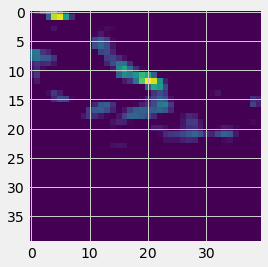

In [0]:
plt.imshow(submission.iloc[400,:][1:].astype('float64').values.reshape(40,40)) # 강수량~~!!

In [0]:
submission.astype('float64').values

array([[2985801.,       0.,       0., ...,       0.,       0.,       0.],
       [2985802.,       0.,       0., ...,       0.,       0.,       0.],
       [2985803.,       0.,       0., ...,       0.,       0.,       0.],
       ...,
       [3128802.,       0.,       0., ...,       0.,       0.,       0.],
       [3128808.,       0.,       0., ...,       0.,       0.,       0.],
       [3128811.,       0.,       0., ...,       0.,       0.,       0.]])

In [0]:
submission.iloc[:,1:].max().describe()

count    1600.000000
mean        5.817770
std         1.487400
min         0.834990
25%         4.821857
50%         5.791486
75%         6.827300
max        10.469974
dtype: float64